In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import glob, time, pickle
import cv2
from lesson_functions import *
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from lesson_functions import *
# NOTE: the next import is only valid for scikit-learn version <= 0.17
# for scikit-learn >= 0.18 use:
from sklearn.model_selection import train_test_split
#from sklearn.cross_validation import train_test_split
from moviepy.editor import VideoFileClip
%matplotlib inline

### Train the classifier
This part is closely followed the script **search_and_classify.py** taught in Session 34.

In [2]:
def train(c=10, color_space='YCrCb', spatial_size=(16, 16),
            hist_bins=24, orient=8, 
            pix_per_cell=8, cell_per_block=1, hog_channel=0,
            spatial_feat=True, hist_feat=True, hog_feat=True, save=False, quick=True):
    # Read in cars and notcars
    cars = [f for f in glob.iglob('vehicles/**/*.png', recursive=True)]
    notcars = [f for f in glob.iglob('non-vehicles/**/*.png', recursive=True)]
    
    # Reduce the sample size
    if quick:
        np.random.seed(123)
        sample_size = 2000
        cars = [cars[i] for i in np.random.choice(len(cars), sample_size)]
        notcars = [notcars[i] for i in np.random.choice(len(notcars), sample_size)]

    car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
    notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

    X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)

    # Define the labels vector
    y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))
    # Split up data into randomized training and test sets
    X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=1234)

    print('Using:',orient,'orientations,', hist_bins, 'hist bins and',
         spatial_size[0], 'sqr spatial bins')
    print('Feature vector length:', len(X_train[0]))
    #svc = svm.LinearSVC()    
    svc = svm.SVC(C=c,class_weight={0:0.9, 1:0.1})
    
    # Check the training time for the SVC
    t=time.time()
    svc.fit(X_train, y_train)
    t2 = time.time()
    print(round(t2-t, 2), 'Seconds to train SVC...')

    # Check the score of the SVC
    weights = np.ones(len(y_test))
    weights[y_test==0] = 9
    print('Test Accuracy of SVC = %.5f' % svc.score(X_test, y_test, sample_weight=weights))
    # save the model to disk    
    if save:
        dist_pickle = {'svc': svc,
                   'x_scaler': X_scaler,
                   'orient': orient,
                   'pix_per_cell': pix_per_cell,
                   'cell_per_block': cell_per_block,
                   'spatial_size': spatial_size,
                   'hist_bins': hist_bins,
                   'color_space': color_space,
                   'hog_channel': hog_channel,
                   'spatial_feat': spatial_feat,
                   'hog_feat': hog_feat,
                   'hist_feat': hist_feat}
        pickle.dump(dist_pickle, open('svc_c'+str(c)+'.pkl', 'wb'))


#### Tweak paramters

In [3]:
for o in [4,6,9]:
    for hb in [16,32]:
        for ss in [8,16]:
            train(hist_bins=hb, spatial_size=(ss, ss), orient=o)

Using: 4 orientations, 16 hist bins and 8 sqr spatial bins
Feature vector length: 480
2.82 Seconds to train SVC...
Test Accuracy of SVC = 0.99113
Using: 4 orientations, 16 hist bins and 16 sqr spatial bins
Feature vector length: 1056
5.64 Seconds to train SVC...
Test Accuracy of SVC = 0.98935
Using: 4 orientations, 32 hist bins and 8 sqr spatial bins
Feature vector length: 512
2.89 Seconds to train SVC...
Test Accuracy of SVC = 0.99138
Using: 4 orientations, 32 hist bins and 16 sqr spatial bins
Feature vector length: 1088
5.78 Seconds to train SVC...
Test Accuracy of SVC = 0.98986
Using: 6 orientations, 16 hist bins and 8 sqr spatial bins
Feature vector length: 608
3.73 Seconds to train SVC...
Test Accuracy of SVC = 0.99138
Using: 6 orientations, 16 hist bins and 16 sqr spatial bins
Feature vector length: 1184
9.46 Seconds to train SVC...
Test Accuracy of SVC = 0.98859
Using: 6 orientations, 32 hist bins and 8 sqr spatial bins
Feature vector length: 640
3.87 Seconds to train SVC...
Tes

In [3]:
for c in [1,10,100,1000]:
    print('c =',c)
    train(c=c, hist_bins=16, spatial_size=(8, 8), orient=4)

c = 1
Using: 4 orientations, 16 hist bins and 8 sqr spatial bins
Feature vector length: 480
4.16 Seconds to train SVC...
Test Accuracy of SVC = 0.98301
c = 10
Using: 4 orientations, 16 hist bins and 8 sqr spatial bins
Feature vector length: 480
3.26 Seconds to train SVC...
Test Accuracy of SVC = 0.99113
c = 100
Using: 4 orientations, 16 hist bins and 8 sqr spatial bins
Feature vector length: 480
2.96 Seconds to train SVC...
Test Accuracy of SVC = 0.99138
c = 1000
Using: 4 orientations, 16 hist bins and 8 sqr spatial bins
Feature vector length: 480
3.05 Seconds to train SVC...
Test Accuracy of SVC = 0.99138


In [4]:
train(c=100, hist_bins=16, spatial_size=(8, 8), orient=4, quick=False, save=True)

Using: 4 orientations, 16 hist bins and 8 sqr spatial bins
Feature vector length: 480
24.22 Seconds to train SVC...
Test Accuracy of SVC = 0.99404


### Load the pre-trained model

In [5]:
dist_pickle = pickle.load( open("svc_c100.pkl", "rb" ) )
svc = dist_pickle["svc"]
X_scaler = dist_pickle["x_scaler"]
orient = dist_pickle["orient"]
pix_per_cell = dist_pickle["pix_per_cell"]
cell_per_block = dist_pickle["cell_per_block"]
spatial_size = dist_pickle["spatial_size"]
hist_bins = dist_pickle["hist_bins"]
color_space = dist_pickle["color_space"]
hog_channel = dist_pickle["hog_channel"]
spatial_feat = dist_pickle["spatial_feat"]
hist_feat = dist_pickle["hist_feat"]
hog_feat = dist_pickle["hog_feat"]

### Find the region of interest 

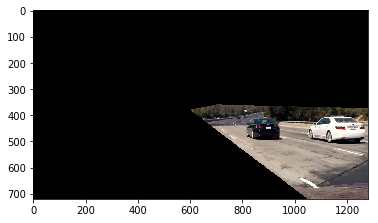

In [6]:
img= mpimg.imread('test_images/test1.jpg')
mask = np.zeros_like(img)
vertices = np.array([[(1050,720),(600, 380),(700, 360), (16000,720)]], dtype=np.int32)
cv2.fillPoly(mask, vertices, (255,255,255))
masked_image = cv2.bitwise_and(img, mask)
plt.imshow(masked_image)

### Pipeline to process the image and detect vehicles

In [7]:
x0 = 650
y0 = 360
x1 = 1280
y1 = 720

def process_image(image):
    draw_image = np.copy(image)
    image = image.astype(np.float32)/255    
    windows = [((700, 380), (1280, 500)), ((800, 400), (1280, 720))]
    windows = transform(windows,x1,y1) #shift and flip
    scales = [0.85,1.8]
    small_img = image[y1:y0:-1,x1:x0:-1,:]
    hot_windows = find_cars(small_img, mask[y1:y0:-1,x1:x0:-1,0], windows, scales, 
                        svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
    window_img = draw_boxes(draw_image, transform(hot_windows,x1,y1), color=(0, 0, 255), thick=2)    
    if not visualize:
        window_img = threshold_boxes(window_img, small_img, hot_windows, 4, 1, x1, y1, color=(255, 255, 0), thick=6)    
        return window_img
    else:
        window_img, heat, small_window_img = threshold_boxes(window_img, small_img, hot_windows, 
                                                         4, 1, x1, y1, color=(255, 255, 0), thick=6, vis=True)
        return window_img, heat, small_window_img
    
    
    

### Apply the pipeline to test images

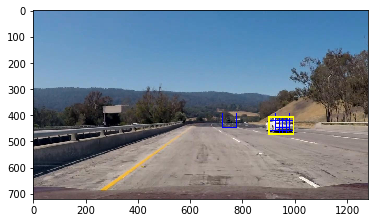

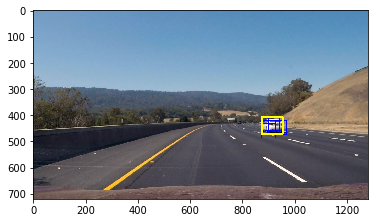

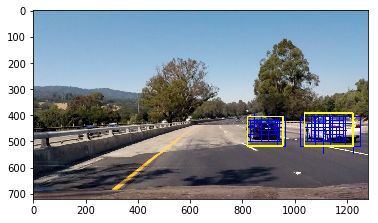

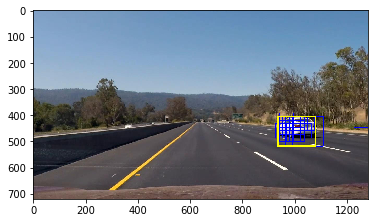

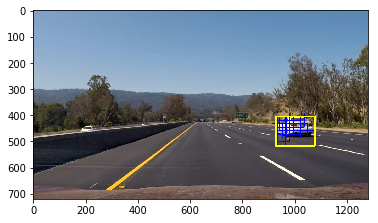

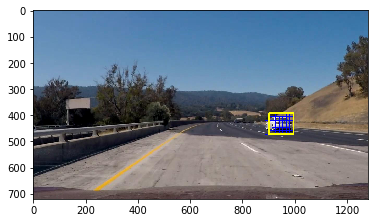

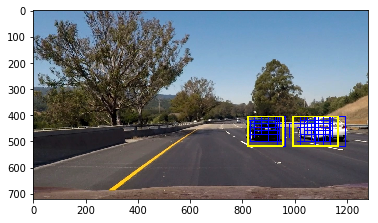

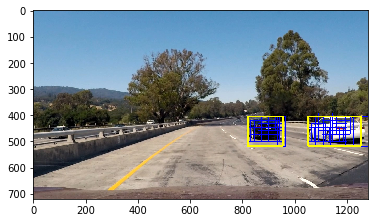

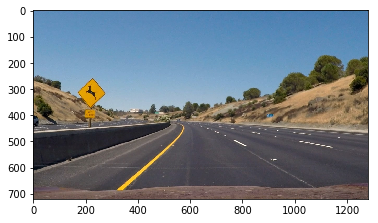

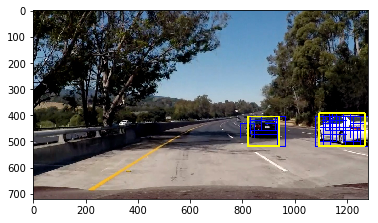

In [8]:
visualize = False
for f in glob.glob('test_images/*.jpg'):
    image = mpimg.imread(f)
    window_img = process_image(image)
    plt.figure()
    plt.imshow(window_img)    

### Process the video

In [9]:
visualize = False
#clip1 = VideoFileClip('project_video.mp4').subclip(16,20).fl_image(process_image)  #road sign
#clip1 = VideoFileClip('project_video.mp4').subclip(23,25).fl_image(process_image)  #false positive
#clip1 = VideoFileClip('project_video.mp4').subclip(5,7).fl_image(process_image)  #false positive
clip1 = VideoFileClip('project_video.mp4').fl_image(process_image)
#clip1 = VideoFileClip('test_video.mp4').fl_image(process_image)
%time clip1.write_videofile('video.mp4', audio=False)

[MoviePy] >>>> Building video video.mp4
[MoviePy] Writing video video.mp4


100%|█████████▉| 1260/1261 [25:23<00:01,  1.23s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: video.mp4 

CPU times: user 23min 15s, sys: 2.31 s, total: 23min 18s
Wall time: 25min 25s


## More details about the pipeline
### Feature extraction
Spatial binary, color histogram, histogram of oriented gradients (HOG)

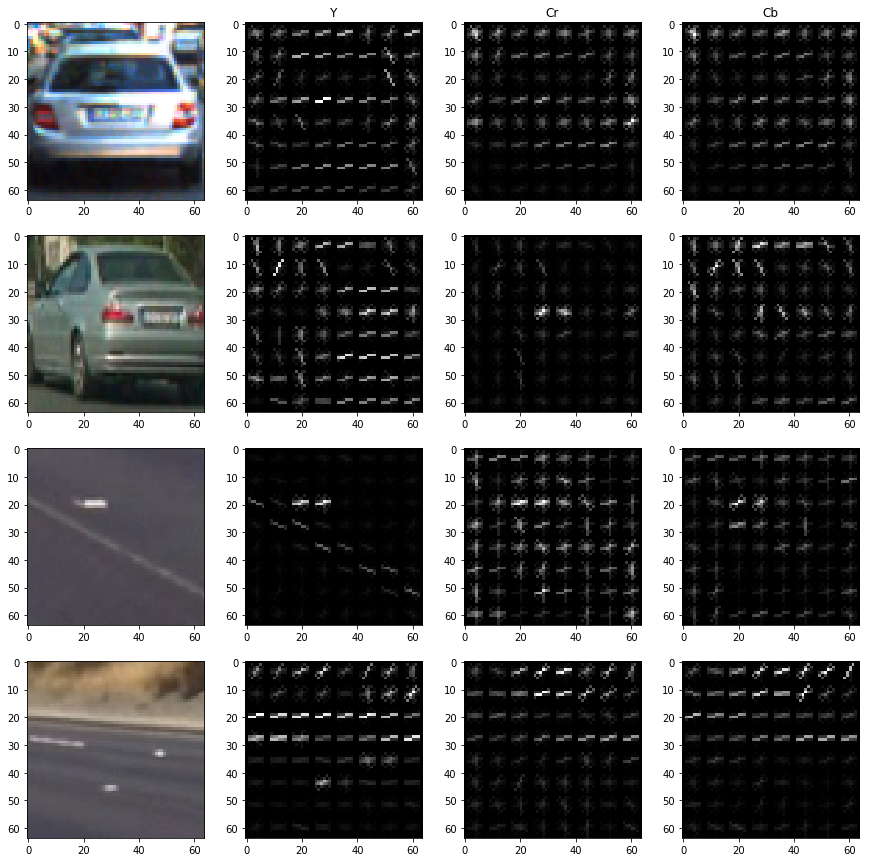

In [10]:
img1 = 'vehicles/KITTI_extracted/40.png'
img2 = 'vehicles/GTI_Right/image0224.png'
img3 = 'non-vehicles/Extras/extra1654.png'
img4 = 'non-vehicles/Extras/extra1753.png'
imgs = [img1, img2, img3, img4]
f, ax = plt.subplots(4,4, figsize=(15,15))
for i, f in enumerate(imgs):
    image =  mpimg.imread(f)
    feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
    hog0, hog0img = get_hog_features(feature_image[:,:,0], 9, pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=True)
    hog1, hog1img = get_hog_features(feature_image[:,:,1], 9, pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=True)
    hog2, hog2img = get_hog_features(feature_image[:,:,2], 9, pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=True)
    ax[i,0].imshow(image)
    ax[i,1].imshow(hog0img,cmap='gray')
    ax[i,2].imshow(hog1img,cmap='gray')
    ax[i,3].imshow(hog2img,cmap='gray')
    if i==0:
        ax[0,1].set_title('Y')
        ax[0,2].set_title('Cr')
        ax[0,3].set_title('Cb')
    

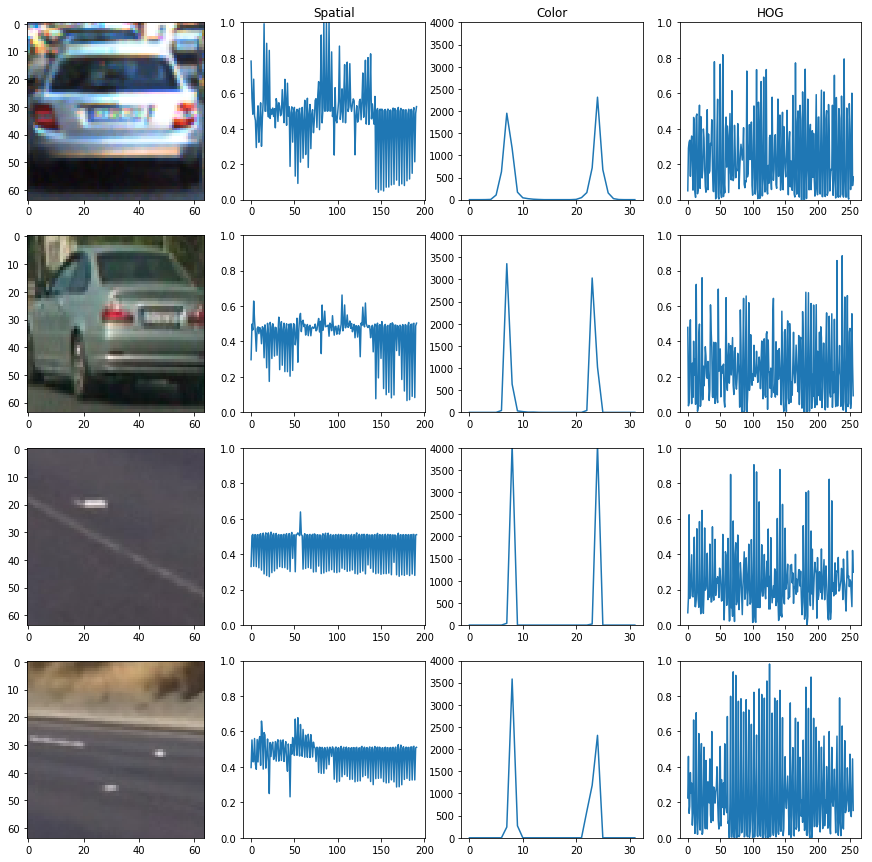

In [11]:
f, ax = plt.subplots(4,4, figsize=(15,15))
for i, f in enumerate(imgs):
    image =  mpimg.imread(f)
    feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
    spatial_features = bin_spatial(feature_image, size=spatial_size)
    hist_features = color_hist(feature_image, color_space, nbins=hist_bins)
    hog0 = get_hog_features(feature_image[:,:,0], orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True)     
    ax[i,0].imshow(image)
    ax[i,1].plot(spatial_features)
    ax[i,1].set_ylim([0,1])
    ax[i,2].plot(hist_features)
    ax[i,2].set_ylim([0,4000])
    ax[i,3].plot(hog0)
    ax[i,3].set_ylim([0,1])
    if i==0:
        ax[0,1].set_title('Spatial')
        ax[0,2].set_title('Color')
        ax[0,3].set_title('HOG')
            

### Multiple detections & false positives
I use the method taught in Sesson 37 to combine multiple detections into a single one and to reject false positives.

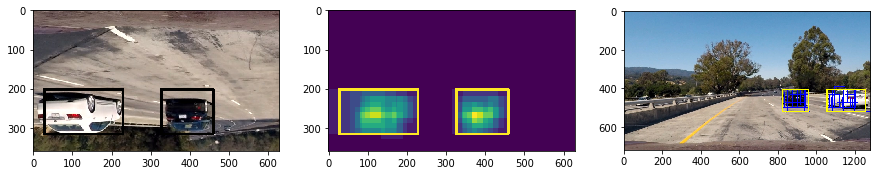

In [12]:
visualize = True
image = mpimg.imread('test_images/test1.jpg')
#i1 = process_image(image)
window_img, heat, small_window_img = process_image(image)
f, ax = plt.subplots(1, 3, figsize=(15,10))
ax[0].imshow(small_window_img)
ax[1].imshow(heat)
ax[2].imshow(window_img)    